In [2]:
# Import important liabraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.ar_model import AutoReg
import time

In [3]:
# reading dataset and make it to series, because AR is effective in series only
df=pd.read_csv('train (1).csv',parse_dates=['Datetime'])
y=df[['Datetime','Global_active_power']].set_index('Datetime').squeeze()
print(y.shape)
print(y.info())
y.head()

(26671,)
<class 'pandas.core.series.Series'>
DatetimeIndex: 26671 entries, 2006-12-16 17:00:00 to 2009-12-31 23:00:00
Series name: Global_active_power
Non-Null Count  Dtype  
--------------  -----  
26671 non-null  float64
dtypes: float64(1)
memory usage: 416.7 KB
None


Datetime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
Name: Global_active_power, dtype: float64

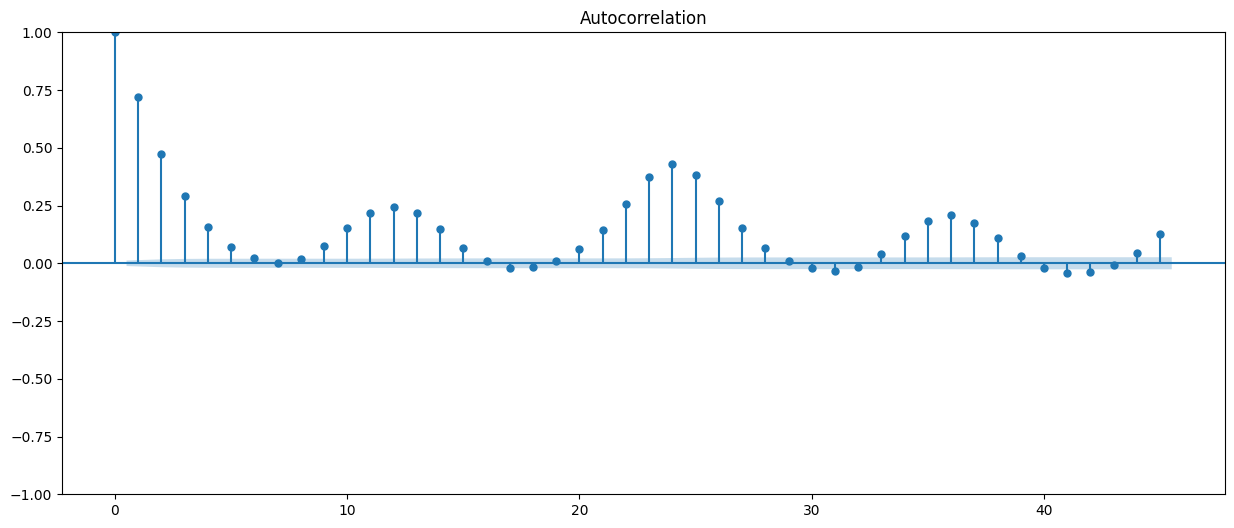

In [4]:
# Acf plot to show how many lags are correlated
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(y,ax=ax);

In [5]:
# correlation between y, and lag of y
y.corr(y.shift(1))

0.7191840981574998

In [6]:
# correlation between y, and lag of 2y
y.corr(y.shift(2))

0.47241494953864327

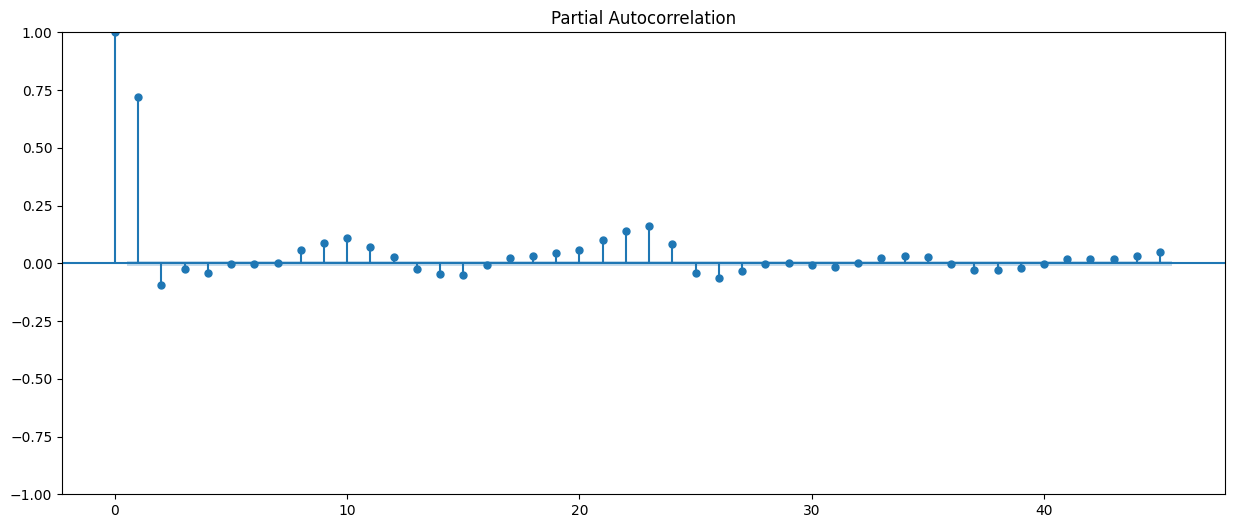

In [8]:
# Pacf plot to more validate the acf_plot
fig,ax=plt.subplots(figsize=(15,6))
plot_pacf(y,ax=ax);

In [9]:
# split the data into 95% training and 5% for testing
cuttoff=int(len(y)*0.95)
y_train = y.iloc[:cuttoff]
y_test = y.iloc[cuttoff:]
print(len(y_test))

1334


In [10]:
# some validations
print(y_train.head(1))
print(y_train.shape)
print(y_train.tail(1))
print(y_test.shape)
print(y_test.head(1))
print(y_test.tail(1))

Datetime
2006-12-16 17:00:00    4.222889
Name: Global_active_power, dtype: float64
(25337,)
Datetime
2009-11-06 09:00:00    1.792467
Name: Global_active_power, dtype: float64
(1334,)
Datetime
2009-11-06 10:00:00    1.400567
Name: Global_active_power, dtype: float64
Datetime
2009-12-31 23:00:00    1.6905
Name: Global_active_power, dtype: float64


In [11]:
# baseline model
y_pred_baseline = [y_train.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline,y_train)

print("Mean Global active power Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Global active power Reading: 1.09
Baseline MAE: 0.74


In [13]:
%%capture
# Create dictionary to store MAEs
p_params = range(1, 31)
maes = []
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Note start time
    start_time = time.time()
    # Train model
    model = AutoReg(y_train,p).fit()
    # Calculate model training time
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained AR {elapsed_time} seconds.")
    # Generate in-sample (training) predicions
    y_pred = model.predict().dropna()
    # Calculate training MAE
    mae = mean_absolute_error(y_train.iloc[p:],y_pred)
    # Append MAE to list in dictionary
    maes.append(mae)
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

In [23]:
# finding best p value for which the lowest mean_absolute_error
mae_series.sort_values()

30    0.420318
28    0.420337
29    0.420363
27    0.420370
26    0.420412
25    0.420992
24    0.421557
23    0.423878
22    0.431404
21    0.438242
20    0.441469
19    0.442618
18    0.443057
12    0.443211
14    0.443213
13    0.443215
11    0.443479
17    0.443488
15    0.443516
16    0.443562
10    0.445369
9     0.449788
8     0.453505
5     0.454784
6     0.454809
7     0.454821
4     0.454858
3     0.455610
2     0.455728
1     0.457054
Name: mae, dtype: float64

In [24]:
best_p=30
best_model=AutoReg(y_train,best_p).fit()
best=best_model.predict().dropna()
y_train_resid = y_train - best
y_train_resid.name = "residuals"
y_train_resid.tail()

c:\Users\Basit Khan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


2009-11-06 05:00:00    0.033566
2009-11-06 06:00:00    0.581330
2009-11-06 07:00:00   -0.251458
2009-11-06 08:00:00   -0.247659
2009-11-06 09:00:00    0.317545
Name: residuals, dtype: float64

Text(0.5, 1.0, 'Best Model, Training Residuals')

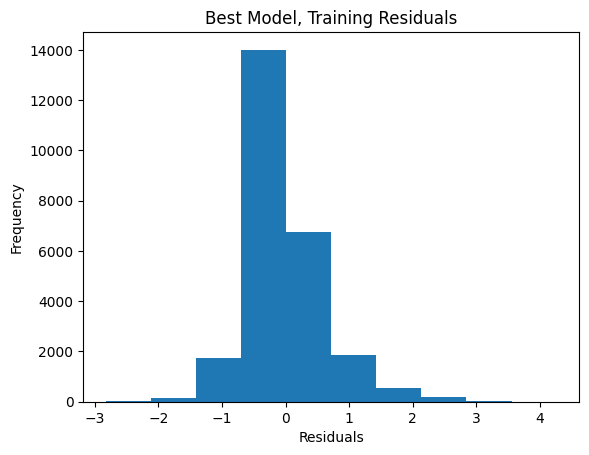

In [18]:
# Plot histogram of residuals
plt.hist(y_train_resid)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Best Model, Training Residuals')

In [19]:
y_train_resid.dropna(inplace=True)

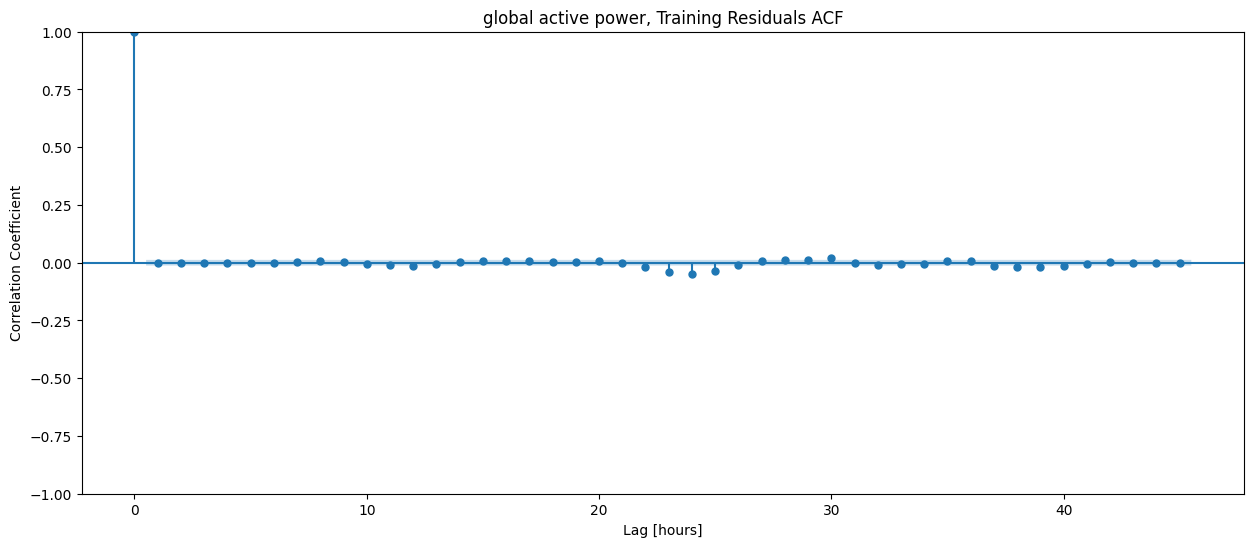

In [21]:
# acf_plot of residuals
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid , ax=ax)
plt.xlabel('Lag [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('global active power, Training Residuals ACF');

In [22]:
%%capture
# validation using walk forward validation
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=30).fit()
    next_pred=model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred, index=[y_test.index[i]])])
    history = pd.concat([history, pd.Series(next_pred, index=[y_test.index[i]])])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

In [32]:
y_pr = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(y_pr, 2))

Test MAE (walk forward validation): 0.76


In [13]:
# train the model for best possible correlated lags
model=AutoReg(y_train,lags=25).fit()

c:\Users\Basit Khan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [14]:
# droping NAN values of predicting lags and mean_abslute_error
y_pred = model.predict().dropna()
mae=mean_absolute_error(y_train.iloc[25:],y_pred)
mae

0.42099206061637207

In [15]:
# residual errors for model
model.resid

Datetime
2006-12-17 18:00:00    0.684317
2006-12-17 19:00:00   -0.304167
2006-12-17 20:00:00    0.663038
2006-12-17 21:00:00    0.071111
2006-12-17 22:00:00   -1.024743
                         ...   
2009-11-06 05:00:00    0.023114
2009-11-06 06:00:00    0.570948
2009-11-06 07:00:00   -0.245010
2009-11-06 08:00:00   -0.205172
2009-11-06 09:00:00    0.345865
Length: 25312, dtype: float64

<Axes: >

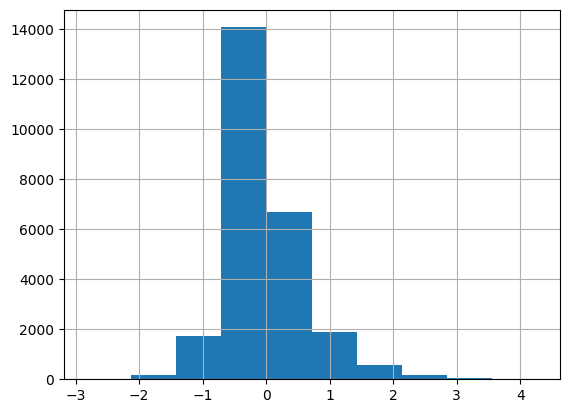

In [16]:
model.resid.hist()

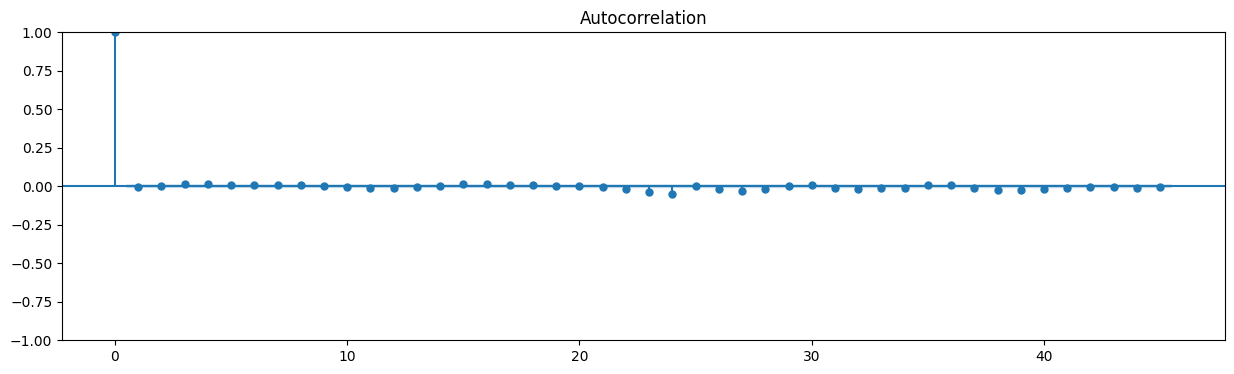

In [17]:
fig,ax=plt.subplots(figsize=(15,4))
plot_acf(model.resid,ax=ax);

In [18]:
# predicting test data
y_pred_test=model.predict(y_test.index.min(),
                          y_test.index.max())
test_mae=mean_absolute_error(y_test,y_pred_test)
test_mae

c:\Users\Basit Khan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


0.7663695455605859

In [19]:
# making data frame for y test and predicting values
y_pred=pd.DataFrame({'y_test':y_test,'y_pred':y_pred_test},index=y_test.index)
y_pred.tail()

,y_test,y_pred
Datetime,,
2009-12-31 19:00:00,3.062867,1.084646
2009-12-31 20:00:00,2.842500,1.084646
2009-12-31 21:00:00,2.875367,1.084646
2009-12-31 22:00:00,2.034367,1.084646
2009-12-31 23:00:00,1.690500,1.084646


In [20]:
px.line(y_pred,labels={'value':'Global active power'})

### Model shows the skewness of accurecy to the mean of whole data.
### Initially model was doing well but over time and increasing number of data points model performace decreasing and a decreased to straight line
### Because the Auto Regressive model not effective where the data points for the prediction are more.
### So I move to the ARIMA model for next